# Initialisation

## Téléchargement des libraires

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
import seaborn as sns
import time
from sklearn.metrics import accuracy_score
from scipy.io import arff
from matplotlib.colors import LinearSegmentedColormap

from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Activation, LSTM, Dropout, SimpleRNN, GRU
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.optimizers import Adam

## Téléchargements des datasets

In [ ]:
train_url = "./ECG200/ECG200_TRAIN.txt"
test_url = "./ECG200/ECG200_TEST.txt"

train_data = pd.read_csv(train_url, sep='\s+', header=None)
test_data = pd.read_csv(test_url, sep='\s+', header=None)

train_data.columns = ['Label'] + [f'Signal_{i}' for i in range(1, len(train_data.columns))]
test_data.columns = ['Label'] + [f'Signal_{i}' for i in range(1, len(test_data.columns))]

## Separation des caractéristiques et des étiquettes

In [ ]:
x_train = train_data.drop('Label', axis=1).values
y_train = train_data['Label'].values

x_test = test_data.drop('Label', axis=1).values
y_test = test_data['Label'].values

y_train = (y_train + 1) // 2
y_test = (y_test + 1) // 2

## Initialisation des données communes

In [ ]:
# Nombre de classes
num_classes = len(train_data['Label'].unique())

# Nombre de points par élément
num_points_per_element = train_data['Label'].value_counts()  # On soustrait 1 pour la colonne 'Label'

# Donnees pour les modeles
activation_method = 'sigmoid'

optimizer_algo = Adam(learning_rate=0.001)
loss_method = 'mse'
list_metrics = ['accuracy']

batch_size=10
percentage_of_train_as_validation = 0.3

monitor_method = 'val_loss'
early_stopping = EarlyStopping(monitor=monitor_method, patience=20)

# Pour certains graphiques
offset = 0.1
# Créer une colormap personnalisée allant du bleu au rouge
colors_bar_plot = [(0, 'red'), (0.5, 'white'), (1, 'blue')]
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors_bar_plot)

# Visualisation des données

## Premier aperçu

In [ ]:
# Nombre de classes
num_classes = len(train_data['Label'].unique())

# Nombre de données par classe
data_per_class_train = train_data['Label'].value_counts()
data_per_class_test = test_data['Label'].value_counts()

# Nombre de points par élément
num_points_per_element = train_data.shape[1] - 1  # Soustrait 1 pour la colonne 'Label'

# Nombre d'éléments avec un ou plusieurs points manquants par classe
missing_data_train = train_data.groupby('Label').apply(lambda x: x.isnull().sum(axis=1).sum())
missing_data_test = test_data.groupby('Label').apply(lambda x: x.isnull().sum(axis=1).sum())

print("Nombre d'éléments dans train : ", len(train_data))
print("Nombre d'éléments dans test : ", len(test_data), "\n")

print("Nombre de classes :", num_classes, "\n")
print("Nombre de points par élément :", num_points_per_element, "\n\n")

print("\nNombre de points manquants par classe :\n")
print("   Dataset   | Train | Test\n")
print("  Normal(1)  |  ", missing_data_train.get(1, 0), "  | ", missing_data_test.get(1, 0), "\n")
print("Infarctus(-1)|  ", missing_data_train.get(-1, 0), "  | ", missing_data_test.get(-1, 0), "\n")

print("\nNombre de données par classe :\n")
print("   Dataset   | Train | Test\n")
print("  Normal(1)  | ", data_per_class_train.get(1, 0), " | ", data_per_class_test.get(1, 0), "\n")
print("Infarctus(-1)| ", data_per_class_train.get(-1, 0), "  | ", data_per_class_test.get(-1, 0), "\n")

Nombre d'éléments dans train :  100
Nombre d'éléments dans test :  100 

Nombre de classes : 2 

Nombre de points par élément : 96 



Nombre de points manquants par classe :

   Dataset   | Train | Test

  Normal(1)  |   0   |  0 

Infarctus(-1)|   0   |  0 


Nombre de données par classe :

   Dataset   | Train | Test

  Normal(1)  |  69  |  64 

Infarctus(-1)|  31   |  36 



## Représentation graphique de certains éléments

### Representation de quelques elements

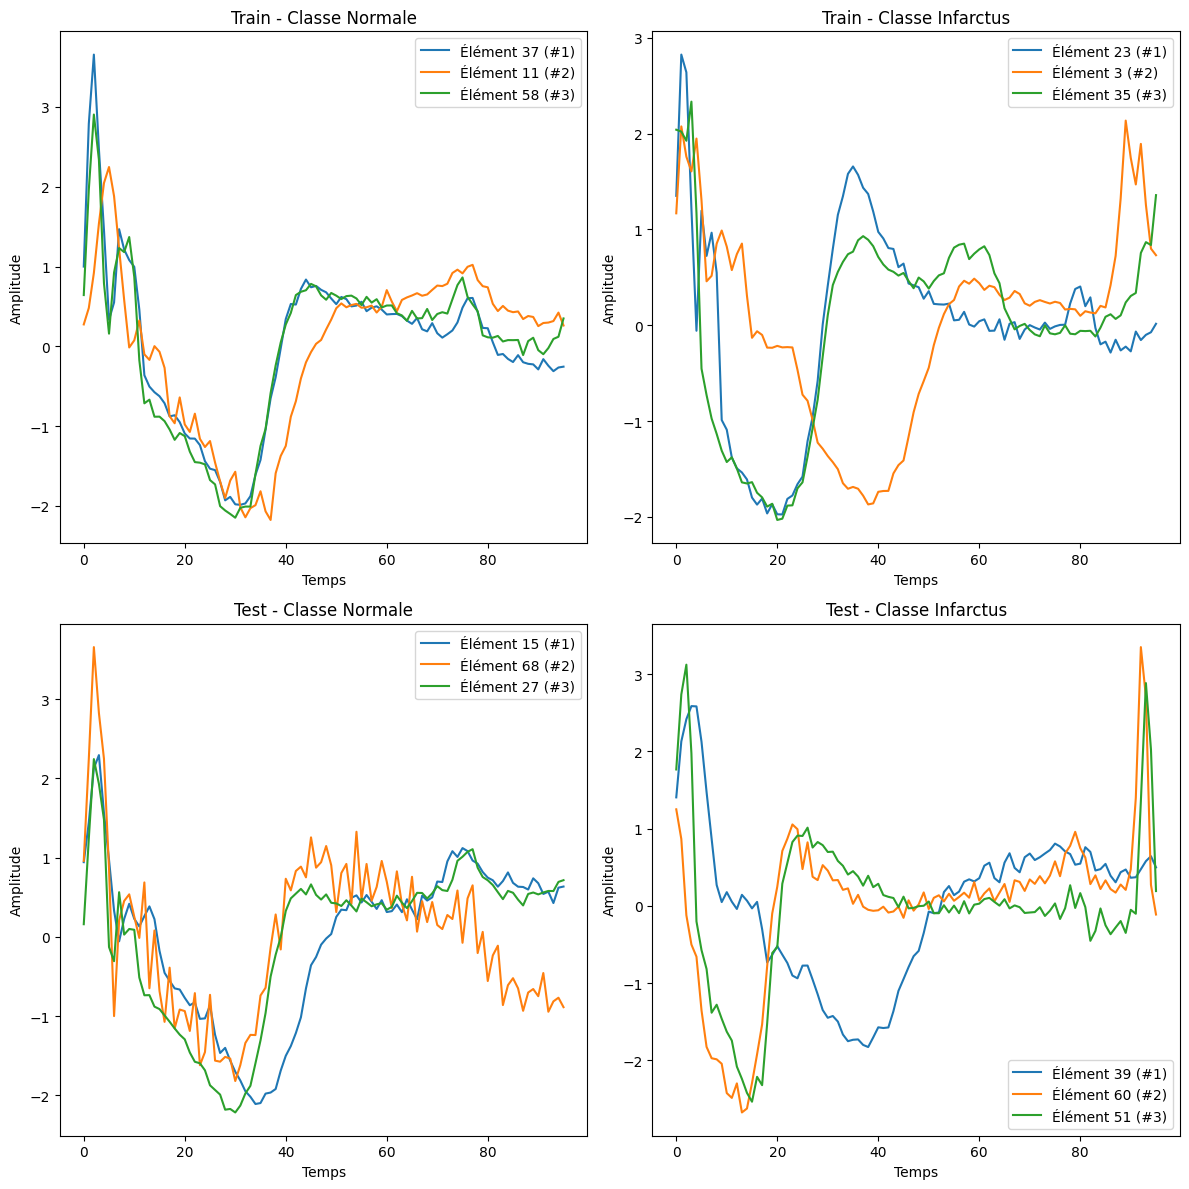

In [ ]:
total_normal_train = train_data[train_data['Label'] == 1].shape[0]
total_infarct_train = train_data[train_data['Label'] == -1].shape[0]
total_normal_test = test_data[test_data['Label'] == 1].shape[0]
total_infarct_test = test_data[test_data['Label'] == -1].shape[0]

number_of_elements = 3

# Tirage au hasard de 3 éléments de la classe normale, de train
train_normal_indices = np.random.choice(range(total_normal_train), size=number_of_elements, replace=False)
train_normal_samples = train_data[train_data['Label'] == 1].iloc[train_normal_indices, 1:].values
train_normal_sample_numbers = train_data[train_data['Label'] == 1].iloc[train_normal_indices].index.tolist()

# Tirage au hasard de 3 éléments de la classe infarctus, de train
train_infarct_indices = np.random.choice(range(total_infarct_train), size=number_of_elements, replace=False)
train_infarct_samples = train_data[train_data['Label'] == -1].iloc[train_infarct_indices, 1:].values
train_infarct_sample_numbers = train_data[train_data['Label'] == -1].iloc[train_infarct_indices].index.tolist()

# Tirage au hasard de 3 éléments de la classe normale, de test
test_normal_indices = np.random.choice(range(total_normal_test), size=number_of_elements, replace=False)
test_normal_samples = test_data[test_data['Label'] == 1].iloc[test_normal_indices, 1:].values
test_normal_sample_numbers = test_data[test_data['Label'] == 1].iloc[test_normal_indices].index.tolist()

# Tirage au hasard de 3 éléments de la classe infarctus, de test
test_infarct_indices = np.random.choice(range(total_infarct_test), size=number_of_elements, replace=False)
test_infarct_samples = test_data[test_data['Label'] == -1].iloc[test_infarct_indices, 1:].values
test_infarct_sample_numbers = test_data[test_data['Label'] == -1].iloc[test_infarct_indices].index.tolist()

# Création du subplot
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

# Tracé des éléments de la classe normale à gauche
for i, (sample, number) in enumerate(zip(train_normal_samples, train_normal_sample_numbers), start=1):
    axs[0,0].plot(sample, label=f'Élément {number} (#{i})')

axs[0,0].set_title('Train - Classe Normale')
axs[0,0].set_xlabel('Temps')
axs[0,0].set_ylabel('Amplitude')
axs[0,0].legend()

# Tracé des éléments de la classe infarctus à droite
for i, (sample, number) in enumerate(zip(train_infarct_samples, train_infarct_sample_numbers), start=1):
    axs[0,1].plot(sample, label=f'Élément {number} (#{i})')

axs[0,1].set_title('Train - Classe Infarctus')
axs[0,1].set_xlabel('Temps')
axs[0,1].set_ylabel('Amplitude')
axs[0,1].legend()

# Tracé des éléments de la classe normale à gauche
for i, (sample, number) in enumerate(zip(test_normal_samples, test_normal_sample_numbers), start=1):
    axs[1,0].plot(sample, label=f'Élément {number} (#{i})')

axs[1,0].set_title('Test - Classe Normale')
axs[1,0].set_xlabel('Temps')
axs[1,0].set_ylabel('Amplitude')
axs[1,0].legend()

# Tracé des éléments de la classe infarctus à droite
for i, (sample, number) in enumerate(zip(test_infarct_samples, test_infarct_sample_numbers), start=1):
    axs[1,1].plot(sample, label=f'Élément {number} (#{i})')

axs[1,1].set_title('Test - Classe Infarctus')
axs[1,1].set_xlabel('Temps')
axs[1,1].set_ylabel('Amplitude')
axs[1,1].legend()

plt.tight_layout()
plt.show()

### Representation de tous les elements

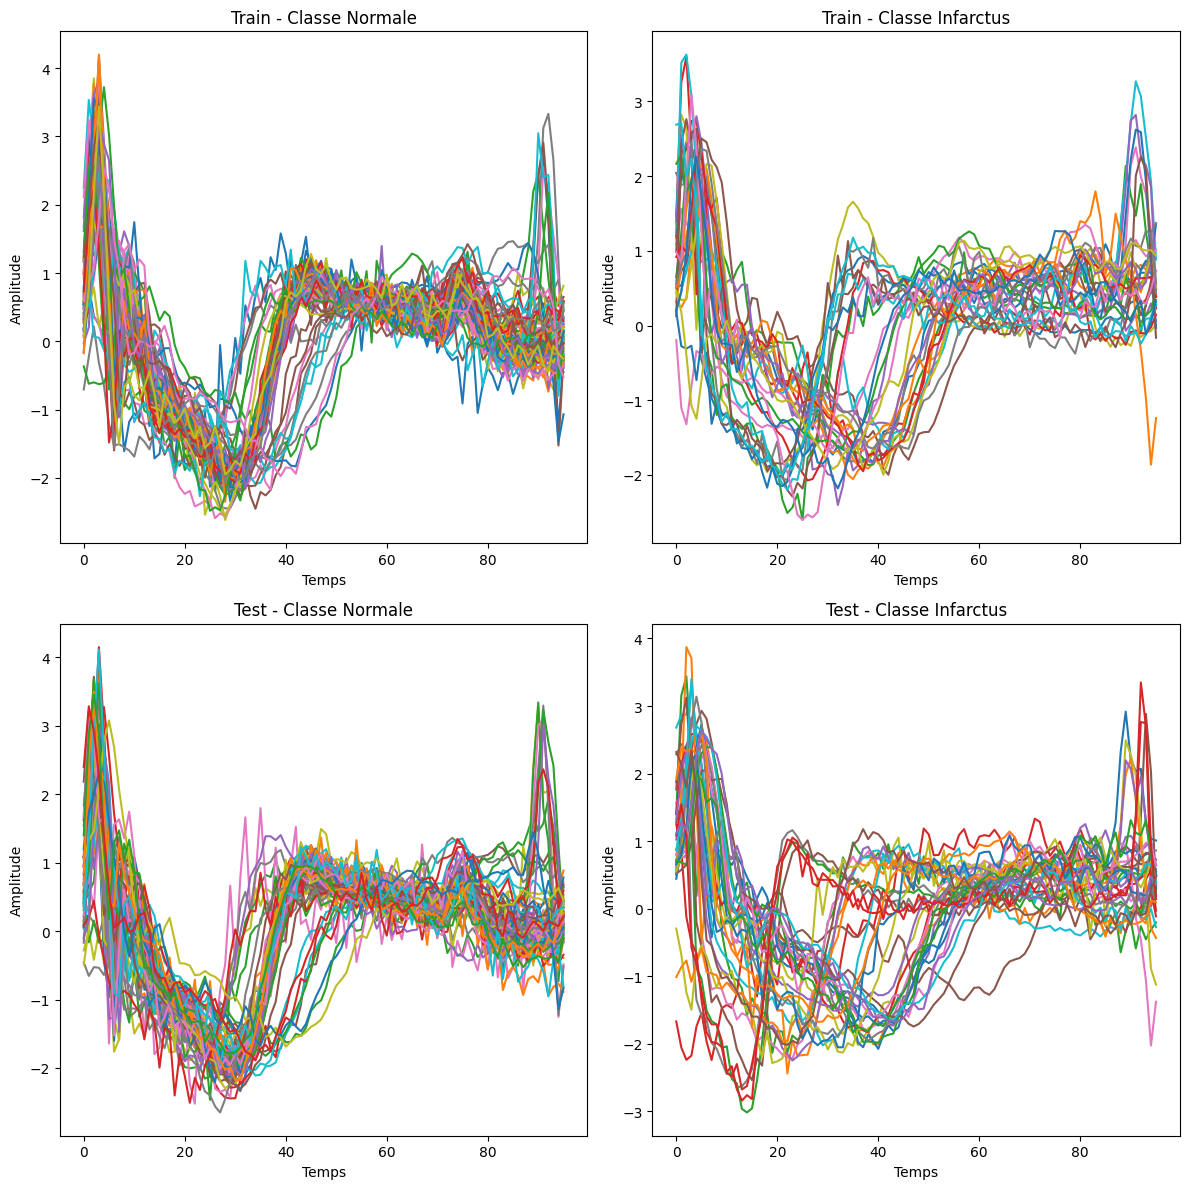

In [ ]:
# Sélection de tous les éléments de la classe normale pour l'ensemble d'entraînement
train_normal_samples = train_data[train_data['Label'] == 1].iloc[:, 1:].values
train_normal_sample_numbers = train_data[train_data['Label'] == 1].index.tolist()

# Sélection de tous les éléments de la classe infarctus pour l'ensemble d'entraînement
train_infarct_samples = train_data[train_data['Label'] == -1].iloc[:, 1:].values
train_infarct_sample_numbers = train_data[train_data['Label'] == -1].index.tolist()

# Sélection de tous les éléments de la classe normale pour l'ensemble de test
test_normal_samples = test_data[test_data['Label'] == 1].iloc[:, 1:].values
test_normal_sample_numbers = test_data[test_data['Label'] == 1].index.tolist()

# Sélection de tous les éléments de la classe infarctus pour l'ensemble de test
test_infarct_samples = test_data[test_data['Label'] == -1].iloc[:, 1:].values
test_infarct_sample_numbers = test_data[test_data['Label'] == -1].index.tolist()

# Création du subplot
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

# Tracé de tous les éléments de la classe normale pour l'ensemble d'entraînement
for i, (sample, number) in enumerate(zip(train_normal_samples, train_normal_sample_numbers), start=1):
    axs[0,0].plot(sample, label=f'Élément {number} (#{i})')

axs[0,0].set_title('Train - Classe Normale')
axs[0,0].set_xlabel('Temps')
axs[0,0].set_ylabel('Amplitude')
#axs[0,0].legend()

# Tracé de tous les éléments de la classe infarctus pour l'ensemble d'entraînement
for i, (sample, number) in enumerate(zip(train_infarct_samples, train_infarct_sample_numbers), start=1):
    axs[0,1].plot(sample, label=f'Élément {number} (#{i})')

axs[0,1].set_title('Train - Classe Infarctus')
axs[0,1].set_xlabel('Temps')
axs[0,1].set_ylabel('Amplitude')
#axs[0,1].legend()

# Tracé de tous les éléments de la classe normale pour l'ensemble de test
for i, (sample, number) in enumerate(zip(test_normal_samples, test_normal_sample_numbers), start=1):
    axs[1,0].plot(sample, label=f'Élément {number} (#{i})')

axs[1,0].set_title('Test - Classe Normale')
axs[1,0].set_xlabel('Temps')
axs[1,0].set_ylabel('Amplitude')
#axs[1,0].legend()

# Tracé de tous les éléments de la classe infarctus pour l'ensemble de test
for i, (sample, number) in enumerate(zip(test_infarct_samples, test_infarct_sample_numbers), start=1):
    axs[1,1].plot(sample, label=f'Élément {number} (#{i})')

axs[1,1].set_title('Test - Classe Infarctus')
axs[1,1].set_xlabel('Temps')
axs[1,1].set_ylabel('Amplitude')
#axs[1,1].legend()

plt.tight_layout()
plt.show()


# Entrainement des modèles

### Multi-Layer Perceptron

In [ ]:
mlp_best_val_loss = float('inf')
mlp_best_history = None
mlp_best_model_weights = None
all_histories_mlp = []

mlp_repetitions = 10
mlp_epochs = 200


for i in range(mlp_repetitions):
    input_shape = (96,)

    # Création du modèle
    input_layer = Input(shape=input_shape)
    hidden_layer1 = Dense(16, activation='relu')(input_layer)
    hidden_layer2 = Dense(16, activation='relu')(hidden_layer1)
    output_layer = Dense(1, activation=activation_method)(hidden_layer2)

    mlp_model = Model(inputs=input_layer, outputs=output_layer)

    # Compilation
    optimizer_algo = Adam(learning_rate=0.001)
    mlp_model.compile(optimizer=optimizer_algo, loss=loss_method, metrics=list_metrics)

    # Entraînement du modèle
    mlp_model_checkpoint = ModelCheckpoint('best-mlp_model.h5', monitor=monitor_method, save_best_only=True)

    mlp_history = mlp_model.fit(x_train, y_train, epochs=mlp_epochs, batch_size=batch_size, verbose=1, validation_split=percentage_of_train_as_validation, callbacks=[mlp_model_checkpoint, early_stopping])

    # Suivi des validations à chaque étape
    all_histories_mlp.append(mlp_history)
    print(f"Étape {i + 1}: val_loss = {min(mlp_history.history['val_loss'])}")

    # Comparaison avec la meilleure perte
    val_loss = min(mlp_history.history['val_loss'])
    if val_loss < mlp_best_val_loss:
        mlp_best_val_loss = val_loss
        mlp_best_history = mlp_history
        mlp_best_model_weights = mlp_model.get_weights()

# Charger les poids du meilleur modèle
mlp_model.set_weights(mlp_best_model_weights)

print("Meilleure perte de validation pour MLP:", min(mlp_best_history.history['val_loss']))

Epoch 1/200
7/7 [==============================] - 7s 80ms/step - loss: 0.2023 - accuracy: 0.7429 - val_loss: 0.1555 - val_accuracy: 0.7667
Epoch 2/200
7/7 [==============================] - 0s 16ms/step - loss: 0.1439 - accuracy: 0.7857 - val_loss: 0.1486 - val_accuracy: 0.8000
Epoch 3/200
1/7 [===>..........................] - ETA: 0s - loss: 0.2202 - accuracy: 0.6000

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - 0s 23ms/step - loss: 0.1363 - accuracy: 0.8000 - val_loss: 0.1447 - val_accuracy: 0.8000
Epoch 4/200
7/7 [==============================] - 0s 33ms/step - loss: 0.1266 - accuracy: 0.8143 - val_loss: 0.1398 - val_accuracy: 0.8333
Epoch 5/200
7/7 [==============================] - 0s 27ms/step - loss: 0.1154 - accuracy: 0.8429 - val_loss: 0.1333 - val_accuracy: 0.8000
Epoch 6/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1040 - accuracy: 0.8714 - val_loss: 0.1294 - val_accuracy: 0.8333
Epoch 7/200
7/7 [==============================] - 0s 29ms/step - loss: 0.0957 - accuracy: 0.8857 - val_loss: 0.1269 - val_accuracy: 0.8333
Epoch 8/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0918 - accuracy: 0.9000 - val_loss: 0.1262 - val_accuracy: 0.8333
Epoch 9/200
7/7 [==============================] - 0s 19ms/step - loss: 0.0845 - accuracy: 0.9143 - val_loss: 0.1232 - val_accuracy: 0.8333
Epoch 10/200
7/7 [==============

### CNN

In [ ]:
cnn_best_val_loss = float('inf')
cnn_best_history = None
cnn_best_model_weights = None
all_histories_cnn = []

cnn_repetitions = 10

filters = 10
kernel_size = 3
stride = 1
padding = 'same'
pool_size = 2
input_shape = (96,1)

for i in range(cnn_repetitions):

    ### Définir les couches du modèle
    input_layer = Input(shape=input_shape)

    # Bloc 1
    conv_layer_1_1 = Conv1D(filters=filters, kernel_size=kernel_size, strides=stride, padding=padding)(input_layer)
    relu_layer_1_1 = Activation('relu')(conv_layer_1_1)
    conv_layer_1_2 = Conv1D(filters=filters, kernel_size=kernel_size, strides=stride, padding=padding)(relu_layer_1_1)
    relu_layer_1_2 = Activation('relu')(conv_layer_1_2)
    pooling_layer_1 = MaxPooling1D(pool_size=pool_size)(relu_layer_1_2)

    # Bloc 2
    conv_layer_2_1 = Conv1D(filters=filters, kernel_size=kernel_size, strides=stride, padding=padding)(pooling_layer_1)
    relu_layer_2_1 = Activation('relu')(conv_layer_2_1)
    conv_layer_2_2 = Conv1D(filters=filters, kernel_size=kernel_size, strides=stride, padding=padding)(relu_layer_2_1)
    relu_layer_2_2 = Activation('relu')(conv_layer_2_2)
    pooling_layer_2 = MaxPooling1D(pool_size=pool_size)(relu_layer_2_2)

    # Couche de sortie
    flattened_layer = Flatten()(pooling_layer_2)
    output_layer = Dense(units=1, activation=activation_method)(flattened_layer)

    # Créer le modèle
    cnn_model = Model(inputs=input_layer, outputs=output_layer)


    ### Compilation
    optimizer_algo = Adam(learning_rate=0.001)
    cnn_model.compile(optimizer=optimizer_algo, loss=loss_method, metrics=list_metrics)

    # Entraînement du modèle
    cnn_epochs = 100

    cnn_model_checkpoint = ModelCheckpoint('best-cnn_model.h5', monitor=monitor_method, save_best_only=True)
    cnn_history = cnn_model.fit(x_train, y_train, batch_size=batch_size, epochs=cnn_epochs, validation_split=percentage_of_train_as_validation,callbacks=[cnn_model_checkpoint, early_stopping])

    # Suivi des validations à chaque étape
    all_histories_cnn.append(cnn_history)
    print(f"Étape {i + 1}: val_loss = {min(cnn_history.history['val_loss'])}")

    # Comparaison de la perte avec la meilleure perte
    val_loss = min(cnn_history.history['val_loss'])
    if val_loss < cnn_best_val_loss:
        cnn_best_val_loss = val_loss
        cnn_best_history = cnn_history
        cnn_best_model_weights = cnn_model.get_weights()

cnn_model.set_weights(cnn_best_model_weights)

print("Meilleure perte de validation pour CNN:", min(cnn_best_history.history['val_loss']))

Epoch 1/100
7/7 [==============================] - 4s 46ms/step - loss: 0.2315 - accuracy: 0.7000 - val_loss: 0.2225 - val_accuracy: 0.6667
Epoch 2/100
7/7 [==============================] - 0s 17ms/step - loss: 0.2070 - accuracy: 0.7000 - val_loss: 0.2135 - val_accuracy: 0.6667
Epoch 3/100
7/7 [==============================] - 0s 14ms/step - loss: 0.1981 - accuracy: 0.7000 - val_loss: 0.2123 - val_accuracy: 0.6667
Epoch 4/100
7/7 [==============================] - 0s 16ms/step - loss: 0.1929 - accuracy: 0.7000 - val_loss: 0.2118 - val_accuracy: 0.6667
Epoch 5/100
7/7 [==============================] - 0s 13ms/step - loss: 0.1905 - accuracy: 0.7000 - val_loss: 0.2094 - val_accuracy: 0.6667
Epoch 6/100
7/7 [==============================] - 0s 16ms/step - loss: 0.1874 - accuracy: 0.7000 - val_loss: 0.2055 - val_accuracy: 0.6667
Epoch 7/100
7/7 [==============================] - 0s 13ms/step - loss: 0.1839 - accuracy: 0.7000 - val_loss: 0.2007 - val_accuracy: 0.6667
Epoch 8/100
7/7 [===

### RNN naïf

In [ ]:
rnn_best_val_loss = float('inf')
rnn_best_history = None
rnn_best_model_weights = None
all_histories_rnn = []

rnn_repetitions = 10
rnn_epochs = 300

nb_neurons = 24
input_shape = (96,1)

for i in range(rnn_repetitions):

    # Définir les couches du modèle
    input_layer_rnn = Input(shape=input_shape)
    rnn_layer_1_rnn = SimpleRNN(units=nb_neurons, return_sequences=True)(input_layer_rnn)
    rnn_layer_2_rnn = SimpleRNN(units=nb_neurons, return_sequences=False)(rnn_layer_1_rnn)
    dropout_layer_rnn = Dropout(rate=0.5)(rnn_layer_2_rnn)
    output_layer_rnn = Dense(units=1, activation=activation_method)(dropout_layer_rnn)

    rnn_model = Model(inputs=input_layer_rnn, outputs=output_layer_rnn)

    # Compilation
    optimizer_algo = Adam(learning_rate=0.001)
    rnn_model.compile(optimizer=optimizer_algo, loss=loss_method, metrics=list_metrics)

    # Entraînement du modèle
    rnn_model_checkpoint = ModelCheckpoint('best-rnn_model.h5', monitor=monitor_method, save_best_only=True)

    rnn_history = rnn_model.fit(x_train, y_train, epochs=rnn_epochs, batch_size=batch_size, verbose=1, validation_split=percentage_of_train_as_validation, callbacks=[rnn_model_checkpoint, early_stopping])

    # Impression de la perte de validation à chaque étape
    all_histories_rnn.append(rnn_history)
    print(f"Étape {i + 1}: val_loss = {min(rnn_history.history['val_loss'])}")

    # Comparaison de la perte de validation avec la meilleure perte de validation actuelle
    val_loss = min(rnn_history.history['val_loss'])
    if val_loss < rnn_best_val_loss:
        rnn_best_val_loss = val_loss
        rnn_best_history = rnn_history
        rnn_best_model_weights = rnn_model.get_weights()

rnn_model.set_weights(rnn_best_model_weights)

print("Meilleure perte de validation pour RNN naïf:", min(rnn_best_history.history['val_loss']))


### LSTM

In [ ]:
lstm_best_val_loss = float('inf')
lstm_best_history = None
lstm_best_model_weights = None
all_histories_lstm = []


input_shape = (96,1)

lstm_epochs = 300
lstm_repetitions = 10

nb_neurons = 24

for i in range(lstm_repetitions):

        # Définir les couches du modèle
        input_layer_lstm = Input(shape=input_shape)
        lstm_layer_1_lstm = LSTM(units=nb_neurons, return_sequences=False)(input_layer_lstm)
        dropout_layer_lstm_2 = Dropout(rate=0.5)(lstm_layer_1_lstm)
        output_layer_lstm = Dense(units=1, activation=activation_method)(dropout_layer_lstm_2)

        lstm_model = Model(inputs=input_layer_lstm, outputs=output_layer_lstm)

        # Compilation
        optimizer_algo = Adam(learning_rate=0.001)
        lstm_model.compile(optimizer=optimizer_algo, loss=loss_method, metrics=list_metrics)

        # Entraînement du modèle
        lstm_model_checkpoint = ModelCheckpoint('best-lstm_model.h5', monitor=monitor_method, save_best_only=True)

        lstm_history = lstm_model.fit(x_train, y_train, epochs=lstm_epochs, batch_size=batch_size, verbose=1, validation_split=percentage_of_train_as_validation, callbacks=[lstm_model_checkpoint, early_stopping])

        # Impression de la perte de validation à chaque étape
        all_histories_lstm.append(lstm_history)
        print(f"Étape {i + 1}: val_loss = {min(lstm_history.history['val_loss'])}")

        # Comparaison de la perte de validation avec la meilleure perte de validation actuelle
        val_loss = min(lstm_history.history['val_loss'])
        if val_loss < lstm_best_val_loss:
            lstm_best_val_loss = val_loss
            lstm_best_history = lstm_history
            lstm_best_model_weights = lstm_model.get_weights()

lstm_model = load_model("best-lstm_model.h5")

print("Meilleure perte de validation pour LSTM:", min(lstm_best_history.history['val_loss']))


# Visualisation des modèles

## Schéma des modèles

### MLP

In [ ]:
mlp_model = load_model("best-mlp_model.h5")

mlp_model.summary()

plot_model(mlp_model, to_file='mlp_model.png', show_shapes=True)

### CNN

In [ ]:
cnn_model = load_model("best-cnn_model.h5")

cnn_model.summary()

plot_model(cnn_model, to_file='cnn_model.png', show_shapes=True)

### LSTM

In [ ]:
lstm_model = load_model("best-lstm_model.h5")

lstm_model.summary()

plot_model(lstm_model, to_file='lstm_model.png', show_shapes=True)

### RNN naif

In [ ]:
rnn_model = load_model("best-rnn_model.h5")

rnn_model.summary()

plot_model(rnn_model, to_file='rnn_model.png', show_shapes=True)

## Graphiques de visualisation des poids

### Graphique MLP

In [ ]:
# Charger le modèle MLP
mlp_model = load_model('best-mlp_model.h5')

# Créer la figure et les subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Afficher le layer 2 en 2D
layer2 = mlp_model.layers[1]
weights2 = layer2.get_weights()[0]
sns.heatmap(weights2, ax=axes[0], cmap=custom_cmap)
axes[0].set_title("Layer 2 Weights")
axes[0].set_ylabel("Value")
axes[0].set_xlabel("Index")

# Afficher le layer 3 en 2D
layer3 = mlp_model.layers[2]
weights3 = layer3.get_weights()[0]
sns.heatmap(weights3, ax=axes[1], cmap=custom_cmap)
axes[1].set_title("Layer 3 Weights")
axes[1].set_ylabel("Value")
axes[1].set_xlabel("Index")

# Afficher le layer 4 en 1D
layer4 = mlp_model.layers[3]
weights4 = layer4.get_weights()[0]
weights4 = [val[0] for val in weights4]
sns.barplot(x=np.arange(len(weights4)),y=weights4, ax=axes[2], palette=sns.color_palette("deep"))
axes[2].set_title("Layer 4 Weights")
axes[2].set_ylabel("Value")
axes[2].set_xlabel("Index")

# Affichage du graphique
plt.tight_layout()
plt.savefig('weight_mlp.png')
plt.show()

### Graphique CNN

In [ ]:
# Charger le modèle
cnn_model = load_model("best-cnn_model.h5")
from matplotlib.gridspec import GridSpec

def visualize_conv_weights(layer_indices, colormap=custom_cmap):
    fig = plt.figure(figsize=(20, 8), dpi=160)
    gs = GridSpec(4, 11, figure=fig, width_ratios=[1]*10 + [0.05])  # Utiliser GridSpec pour la mise en page

    axes = np.empty((4, 10), dtype=object)  # Utiliser un tableau pour stocker les axes des sous-graphiques

    for i, layer_index in enumerate(layer_indices):
        # Récupérer les poids de la couche de convolution spécifiée
        weights = cnn_model.layers[layer_index].get_weights()[0]
        filters = weights.shape[2]

        # Trouver la valeur minimale et maximale des poids pour normaliser la colormap
        min_weight = np.min(weights)
        max_weight = np.max(weights)

        # Créer le graphique pour cette couche
        for filter_index in range(filters):
            ax = fig.add_subplot(gs[i, filter_index])
            im = ax.imshow(weights[:, :, filter_index], cmap=colormap, vmin=min_weight, vmax=max_weight)
            ax.axis('off')
            ax.set_title('Layer {} - Filter {}'.format(layer_index, filter_index + 1))
            axes[i, filter_index] = ax

    # Ajouter une seule légende de barre de couleurs à droite de tous les sous-graphiques
    cbar_ax = fig.add_subplot(gs[:, -1])
    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar.set_label('Weight Value')
    cbar.set_ticks([min_weight, max_weight])

    plt.suptitle('Weights Visualization for Convolution Layers', y=1.02)  # Ajuster la position verticale du titre
    plt.savefig('weight_cnn.png')
    plt.show()


# Exemple d'utilisation pour les couches de convolution spécifiées
visualize_conv_weights(layer_indices=[1, 3, 6, 8])

### Graphique LSTM

In [ ]:
lstm_model = load_model("best-lstm_model.h5")

# Utilisation de la fonction pour visualiser les poids du modèle LSTM avec la nouvelle colormap
def visualize_lstm_weights(model):
    # Récupérer les poids du modèle LSTM
    lstm_weights = lstm_model.get_weights()

    # Visualiser les poids associés aux connexions récurrentes
    recurrent_weights = np.asarray(lstm_weights[0])  # Récupérer les poids récurrents
    plt.figure(figsize=(15, 5))

    # Plot des poids récurrents
    plt.subplot(1, 2, 1)
    sns.barplot(x=np.arange(recurrent_weights.shape[1]), y=recurrent_weights[0], palette=sns.color_palette("deep"))
    plt.xlabel('Output Dimension')
    plt.ylabel('Weight Value')
    plt.title('Recurrent Weights')

    # Visualiser les poids associés aux connexions entre les cellules et les entrées/sorties
    input_weights = np.asarray(lstm_weights[1])  # Récupérer les poids d'entrée

    # Plot des poids d'entrée avec la colormap personnalisée
    plt.subplot(1, 2, 2)
    plt.title('Input Weights')
    plt.imshow(input_weights, cmap=custom_cmap, aspect='auto')
    plt.colorbar(label='Weight Value')
    plt.xlabel('Input Dimension')
    plt.ylabel('Output Dimension')

    plt.tight_layout()
    plt.savefig('weight_lstm.png')
    plt.show()

# Utilisation de la fonction pour visualiser les poids du modèle LSTM
visualize_lstm_weights(lstm_model)

### Graphique RNN naif

In [ ]:
rnn_model = load_model("best-rnn_model.h5")

# Utilisation de la fonction pour visualiser les poids du modèle RNN avec la nouvelle colormap
def visualize_rnn_weights(model):
    # Récupérer les poids du modèle RNN
    rnn_weights = rnn_model.get_weights()

    # Visualiser les poids associés aux connexions récurrentes
    recurrent_weights = np.asarray(rnn_weights[0])  # Récupérer les poids récurrents
    plt.figure(figsize=(10, 5))

    # Plot des poids récurrents
    plt.subplot(1, 2, 1)
    sns.barplot(x=np.arange(recurrent_weights.shape[1]), y=recurrent_weights[0], palette=sns.color_palette("deep"))
    plt.xlabel('Output Dimension')
    plt.ylabel('Weight Value')
    plt.title('Recurrent Weights')

    # Visualiser les poids associés aux connexions entre les cellules et les entrées/sorties
    input_weights = np.asarray(rnn_weights[1])  # Récupérer les poids d'entrée

    # Plot des poids d'entrée avec la colormap personnalisée
    plt.subplot(1, 2, 2)
    plt.title('Input Weights')
    plt.imshow(input_weights, cmap=custom_cmap, aspect='auto')
    plt.colorbar(label='Weight Value')
    plt.xlabel('Input Dimension')
    plt.ylabel('Output Dimension')

    plt.tight_layout()
    plt.savefig('weight_rnn.png')
    plt.show()

# Utilisation de la fonction pour visualiser les poids du modèle RNN
visualize_rnn_weights(rnn_model)


## Tableau de cross-comparaison

In [ ]:
# Créez des listes pour stocker les valeurs des modèles MLP
mlp_iterations = []
mlp_accuracy = []

# Bouclez sur les histoires de chaque modèle MLP
for i, history in enumerate(all_histories_mlp):
    # Stockez le nombre d'itérations (longueur de la liste de pertes)
    iterations = len(history.history['loss'])
    mlp_iterations.append(iterations)

    # Stockez l'accuracy finale (la dernière valeur de la liste d'accuracy)
    accuracy = history.history['accuracy'][-1]
    val_accuracy = history.history['val_accuracy'][-1]
    mlp_accuracy.append((accuracy + val_accuracy) / 2)

# Calculez la moyenne et l'écart type pour les modèles MLP
mean_mlp_iterations = np.mean(mlp_iterations)
std_mlp_iterations = np.std(mlp_iterations)
mean_mlp_accuracy = np.mean(mlp_accuracy)
std_mlp_accuracy = np.std(mlp_accuracy)

# Créez des listes pour stocker les valeurs des modèles CNN
cnn_iterations = []
cnn_accuracy = []

# Bouclez sur les histoires de chaque modèle CNN
for i, history in enumerate(all_histories_cnn):
    # Stockez le nombre d'itérations
    iterations = len(history.history['loss'])
    cnn_iterations.append(iterations)

    # Stockez l'accuracy finale
    accuracy = history.history['accuracy'][-1]
    val_accuracy = history.history['val_accuracy'][-1]
    cnn_accuracy.append((accuracy + val_accuracy) / 2)

# Calculez la moyenne et l'écart type pour les modèles CNN
mean_cnn_iterations = np.mean(cnn_iterations)
std_cnn_iterations = np.std(cnn_iterations)
mean_cnn_accuracy = np.mean(cnn_accuracy)
std_cnn_accuracy = np.std(cnn_accuracy)

# Créez des listes pour stocker les valeurs des modèles RNN
rnn_iterations = []
rnn_accuracy = []

# Bouclez sur les histoires de chaque modèle RNN
for i, history in enumerate(all_histories_rnn):
    # Stockez le nombre d'itérations
    iterations = len(history.history['loss'])
    rnn_iterations.append(iterations)

    # Stockez l'accuracy finale
    accuracy = history.history['accuracy'][-1]
    val_accuracy = history.history['val_accuracy'][-1]
    rnn_accuracy.append((accuracy + val_accuracy) / 2)

# Calculez la moyenne et l'écart type pour les modèles RNN
mean_rnn_iterations = np.mean(rnn_iterations)
std_rnn_iterations = np.std(rnn_iterations)
mean_rnn_accuracy = np.mean(rnn_accuracy)
std_rnn_accuracy = np.std(rnn_accuracy)

# Créez des listes pour stocker les valeurs des modèles LSTM
lstm_iterations = []
lstm_accuracy = []

# Bouclez sur les histoires de chaque modèle LSTM
for i, history in enumerate(all_histories_lstm):
    # Stockez le nombre d'itérations
    iterations = len(history.history['loss'])
    lstm_iterations.append(iterations)

    # Stockez l'accuracy finale
    accuracy = history.history['accuracy'][-1]
    val_accuracy = history.history['val_accuracy'][-1]
    lstm_accuracy.append((accuracy + val_accuracy) / 2)

# Calculez la moyenne et l'écart type pour les modèles LSTM
mean_lstm_iterations = np.mean(lstm_iterations)
std_lstm_iterations = np.std(lstm_iterations)
mean_lstm_accuracy = np.mean(lstm_accuracy)
std_lstm_accuracy = np.std(lstm_accuracy)

# Créez un tableau pour stocker les résultats
results = pd.DataFrame({
    'Model': ['MLP', 'CNN', 'RNN', 'LSTM'],
    'Loop fit': [10, 10, 10, 10],
    'Mean Iterations': [mean_mlp_iterations, mean_cnn_iterations, mean_rnn_iterations, mean_lstm_iterations],
    'Std Iterations': [std_mlp_iterations, std_cnn_iterations, std_rnn_iterations, std_lstm_iterations],
    'Mean Accuracy': [mean_mlp_accuracy, mean_cnn_accuracy, mean_rnn_accuracy, mean_lstm_accuracy],
    'Std Accuracy': [std_mlp_accuracy, std_cnn_accuracy, std_rnn_accuracy, std_lstm_accuracy]
})

# Affichage sur une seule ligne
print(results.to_string(line_width=1000, index=False))

# Performances des modèles

## Comparaison des loss et accuracy de chaque itération

### MLP

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

for i, history in enumerate(all_histories_mlp):
    axes[0].plot(history.history['loss'], label=f'Run {i+1}')
    axes[0].plot(history.history['val_loss'], label=f'Val Run {i+1}', linestyle='dashed')
    axes[1].plot(history.history['accuracy'], label=f'Run {i+1}')
    axes[1].plot(history.history['val_accuracy'], label=f'Val Run {i+1}', linestyle='dashed')

axes[0].set_title('Évolution de la perte (loss)')
axes[0].set_xlabel('Époques')
axes[0].set_ylabel('Loss')
axes[0].legend()

axes[1].set_title('Évolution de la précision (accuracy)')
axes[1].set_xlabel('Époques')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.tight_layout()
plt.savefig('accuracy_train_mlp.png')
plt.show()


### CNN

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

for i, history in enumerate(all_histories_cnn):
    axes[0].plot(history.history['loss'], label=f'Run {i+1}')
    axes[0].plot(history.history['val_loss'], label=f'Val Run {i+1}', linestyle='dashed')
    axes[1].plot(history.history['accuracy'], label=f'Run {i+1}')
    axes[1].plot(history.history['val_accuracy'], label=f'Val Run {i+1}', linestyle='dashed')

axes[0].set_title('Évolution de la perte (loss)')
axes[0].set_xlabel('Époques')
axes[0].set_ylabel('Loss')
axes[0].legend()

axes[1].set_title('Évolution de la précision (accuracy)')
axes[1].set_xlabel('Époques')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.tight_layout()
plt.savefig('accuracy_train_cnn.png')
plt.show()


### LSTM

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

for i, history in enumerate(all_histories_lstm):
    axes[0].plot(history.history['loss'], label=f'Run {i+1}')
    axes[0].plot(history.history['val_loss'], label=f'Val Run {i+1}', linestyle='dashed')
    axes[1].plot(history.history['accuracy'], label=f'Run {i+1}')
    axes[1].plot(history.history['val_accuracy'], label=f'Val Run {i+1}', linestyle='dashed')

axes[0].set_title('Évolution de la perte (loss)')
axes[0].set_xlabel('Époques')
axes[0].set_ylabel('Loss')
axes[0].legend()

axes[1].set_title('Évolution de la précision (accuracy)')
axes[1].set_xlabel('Époques')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.tight_layout()
plt.savefig('accuracy_train_lstm.png')
plt.show()


### RNN

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

for i, history in enumerate(all_histories_cnn):
    axes[0].plot(history.history['loss'], label=f'Run {i+1}')
    axes[0].plot(history.history['val_loss'], label=f'Val Run {i+1}', linestyle='dashed')
    axes[1].plot(history.history['accuracy'], label=f'Run {i+1}')
    axes[1].plot(history.history['val_accuracy'], label=f'Val Run {i+1}', linestyle='dashed')

axes[0].set_title('Évolution de la perte (loss)')
axes[0].set_xlabel('Époques')
axes[0].set_ylabel('Loss')
axes[0].legend()

axes[1].set_title('Évolution de la précision (accuracy)')
axes[1].set_xlabel('Époques')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.tight_layout()
plt.savefig('accuracy_train_rnn.png')
plt.show()

## Comparaison des loss et accuracy des meilleurs modèles

### Visualisation graphique

In [ ]:
plt.figure(figsize=(18, 12))

# Plot loss for MLP
plt.subplot(2, 4, 1)
plt.plot(mlp_best_history.history['loss'], label='Training Loss')
plt.plot(mlp_best_history.history['val_loss'], label='Validation Loss')
plt.title('MLP Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy for MLP
plt.subplot(2, 4, 5)
plt.plot(mlp_best_history.history['accuracy'], label='Training Accuracy')
plt.plot(mlp_best_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('MLP Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss and accuracy for CNN
plt.subplot(2, 4, 2)
plt.plot(cnn_best_history.history['loss'], label='Training Loss')
plt.plot(cnn_best_history.history['val_loss'], label='Validation Loss')
plt.title('CNN Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 4, 6)
plt.plot(cnn_best_history.history['accuracy'], label='Training Accuracy')
plt.plot(cnn_best_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss and accuracy for RNN Naif
plt.subplot(2, 4, 3)
plt.plot(rnn_best_history.history['loss'], label='Training Loss')
plt.plot(rnn_best_history.history['val_loss'], label='Validation Loss')
plt.title('RNN Naif Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 4, 7)
plt.plot(rnn_best_history.history['accuracy'], label='Training Accuracy')
plt.plot(rnn_best_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('RNN Naif Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss and accuracy for LSTM
plt.subplot(2, 4, 4)
plt.plot(lstm_best_history.history['loss'], label='Training Loss')
plt.plot(lstm_best_history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 4, 8)
plt.plot(lstm_best_history.history['accuracy'], label='Training Accuracy')
plt.plot(lstm_best_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('LSTM Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig('all_accuracy.png')
plt.show()


## Mesure du temps d'inférence

In [ ]:
# Fonction pour mesurer le temps d'exécution d'une prédiction
def measure_inference_time(model, data):
    start_time = time.time()
    predictions = model.predict(data)
    inference_time = time.time() - start_time
    return predictions, inference_time

# Faire des prédictions pour chaque modèle et mesurer le temps d'exécution

# Pour le modèle MLP
mlp_predictions, mlp_inference_time = measure_inference_time(mlp_model, x_test)

# Pour le modèle CNN
cnn_predictions, cnn_inference_time = measure_inference_time(cnn_model, x_test)

# Pour le modèle RNN
rnn_predictions, rnn_inference_time = measure_inference_time(rnn_model, x_test)

# Pour le modèle LSTM
lstm_predictions, lstm_inference_time = measure_inference_time(lstm_model, x_test)

# Affichage des temps d'inférence pour chaque modèle
print("Temps d'inférence pour 100 prédictions (en secondes) :")
print("MLP:", mlp_inference_time)
print("CNN:", cnn_inference_time)
print("RNN:", rnn_inference_time)
print("LSTM:", lstm_inference_time)

# Résultats

## Perte et accuracy

### Calculs

In [ ]:
## MLP
mlp_model = load_model('best-mlp_model.h5')
mlp_history = mlp_model.history

# Version 1 : avec tensorflow

mlp_train_loss, mlp_train_accuracy_tf = mlp_model.evaluate(x_train, y_train, verbose=0)
mlp_test_loss, mlp_test_accuracy_tf = mlp_model.evaluate(x_test, y_test, verbose=0)

# Version 2 : avec scikitlearn

mlp_y_train_pred_raw = mlp_model.predict(x_train)
mlp_y_test_pred_raw = mlp_model.predict(x_test)

mlp_y_train_pred = np.where(mlp_y_train_pred_raw > 0.5, 1, 0)
mlp_y_test_pred = np.where(mlp_y_test_pred_raw > 0.5, 1, 0)

mlp_train_accuracy_sk = accuracy_score(y_train, mlp_y_train_pred)
mlp_test_accuracy_sk = accuracy_score(y_test, mlp_y_test_pred)

In [ ]:
## CNN
cnn_model = load_model('best-cnn_model.h5')
cnn_history = cnn_model.history

# Version 1 : avec tensorflow

cnn_train_loss, cnn_train_accuracy_tf = cnn_model.evaluate(x_train, y_train, verbose=0)
cnn_test_loss, cnn_test_accuracy_tf = cnn_model.evaluate(x_test, y_test, verbose=0)

# Version 2 : avec scikitlearn

cnn_y_train_pred_raw = cnn_model.predict(x_train)
cnn_y_test_pred_raw = cnn_model.predict(x_test)

cnn_y_train_pred = np.where(cnn_y_train_pred_raw > 0.5, 1, 0)
cnn_y_test_pred = np.where(cnn_y_test_pred_raw > 0.5, 1, 0)

cnn_train_accuracy_sk = accuracy_score(y_train, cnn_y_train_pred)
cnn_test_accuracy_sk = accuracy_score(y_test, cnn_y_test_pred)

In [ ]:
## RNN
rnn_model = load_model('best-rnn_model.h5')
rnn_history = rnn_model.history

# Version 1 : avec tensorflow

rnn_train_loss, rnn_train_accuracy_tf = rnn_model.evaluate(x_train, y_train, verbose=0)
rnn_test_loss, rnn_test_accuracy_tf = rnn_model.evaluate(x_test, y_test, verbose=0)

# Version 2 : avec scikitlearn

rnn_y_train_pred_raw = rnn_model.predict(x_train)
rnn_y_test_pred_raw = rnn_model.predict(x_test)

rnn_y_train_pred = np.where(rnn_y_train_pred_raw > 0.5, 1, 0)
rnn_y_test_pred = np.where(rnn_y_test_pred_raw > 0.5, 1, 0)

rnn_train_accuracy_sk = accuracy_score(y_train, rnn_y_train_pred)
rnn_test_accuracy_sk = accuracy_score(y_test, rnn_y_test_pred)


In [ ]:
## LSTM
lstm_model = load_model('best-lstm_model.h5')
lstm_history = lstm_model.history

# Version 1 : avec tensorflow

lstm_train_loss, lstm_train_accuracy_tf = lstm_model.evaluate(x_train, y_train, verbose=0)
lstm_test_loss, lstm_test_accuracy_tf = lstm_model.evaluate(x_test, y_test, verbose=0)

# Version 2 : avec scikitlearn

lstm_y_train_pred_raw = lstm_model.predict(x_train)
lstm_y_test_pred_raw = lstm_model.predict(x_test)

lstm_y_train_pred = np.where(lstm_y_train_pred_raw > 0.5, 1, 0)
lstm_y_test_pred = np.where(lstm_y_test_pred_raw > 0.5, 1, 0)

lstm_train_accuracy_sk = accuracy_score(y_train, lstm_y_train_pred)
lstm_test_accuracy_sk = accuracy_score(y_test, lstm_y_test_pred)

### Affichage du tableau

In [ ]:
# Créer un tableau de données avec les résultats
data = {
    'MLP': [mlp_train_loss, mlp_test_loss, mlp_train_accuracy_tf, mlp_train_accuracy_sk, mlp_test_accuracy_tf, mlp_test_accuracy_sk],
    'CNN': [cnn_train_loss, cnn_test_loss, cnn_train_accuracy_tf, cnn_train_accuracy_sk, cnn_test_accuracy_tf, cnn_test_accuracy_sk],
    'LSTM': [lstm_train_loss, lstm_test_loss, lstm_train_accuracy_tf, lstm_train_accuracy_sk, lstm_test_accuracy_tf, lstm_test_accuracy_sk],
    'RNN Naif': [rnn_train_loss, rnn_test_loss, rnn_train_accuracy_tf, rnn_train_accuracy_sk, rnn_test_accuracy_tf, rnn_test_accuracy_sk]
}

# Créer un index pour les lignes
index = ['Loss Train (TensorFlow)', 'Loss Test (TensorFlow)', 'Accuracy Train (TensorFlow)', 'Accuracy Train (ScikitLearn)', 'Accuracy Test (TensorFlow)', 'Accuracy Test (ScikitLearn)']

# Créer un DataFrame pandas avec les données
df = pd.DataFrame(data, index=index)

# Réorganiser les colonnes et les lignes
df = df[['MLP', 'CNN', 'LSTM', 'RNN Naif']]
df = df.loc[['Loss Train (TensorFlow)', 'Loss Test (TensorFlow)', 'Accuracy Train (TensorFlow)', 'Accuracy Train (ScikitLearn)', 'Accuracy Test (TensorFlow)', 'Accuracy Test (ScikitLearn)']]

# Afficher le DataFrame
print(df)

## Visualisation des points réels / prédits



### Erreur MLP

In [ ]:
# Création des listes pour les indices corrects et incorrects (entraînement)
mlp_correct_train_indices = []
mlp_incorrect_train_indices = []

# Parcours des prédictions d'entraînement pour déterminer les indices corrects et incorrects
for i, (real_label, pred_label) in enumerate(zip(y_train, mlp_y_train_pred)):
    if real_label == pred_label:
        mlp_correct_train_indices.append(i)
    else:
        mlp_incorrect_train_indices.append(i)

# Création des listes pour les indices corrects et incorrects (test)
mlp_correct_test_indices = []
mlp_incorrect_test_indices = []

# Parcours des prédictions de test pour déterminer les indices corrects et incorrects
for i, (real_label, pred_label) in enumerate(zip(y_test, mlp_y_test_pred)):
    if real_label == pred_label:
        mlp_correct_test_indices.append(i)
    else:
        mlp_incorrect_test_indices.append(i)


In [ ]:
# Création de la figure et des sous-graphiques
fig, axs = plt.subplots(2, 4, figsize=(16, 10))
fig.suptitle('Comparaison des prédictions MLP')

# Sous-graphique pour les prédictions correctes (entraînement)
axs[0, 0].scatter(mlp_correct_train_indices, y_train[mlp_correct_train_indices], color='blue', label='Real Value')
axs[0, 0].scatter(mlp_correct_train_indices, mlp_y_train_pred[mlp_correct_train_indices]+offset, color='cyan', label='Predicted Value')
axs[0, 0].set_title('Correct Predictions (Train)')
axs[0, 0].set_xlabel('Sample')
axs[0, 0].set_ylabel('Value filtered')
axs[0, 0].legend()

axs[1, 0].scatter(mlp_correct_train_indices, y_train[mlp_correct_train_indices], color='blue', label='Real Value')
axs[1, 0].scatter(mlp_correct_train_indices, mlp_y_train_pred_raw[mlp_correct_train_indices], color='cyan', label='Predicted Value')
axs[1, 0].set_title('Correct Predictions (Train)')
axs[1, 0].set_xlabel('Sample')
axs[1, 0].set_ylabel('Value raw')
axs[1, 0].legend()

# Sous-graphique pour les prédictions incorrectes (entraînement)
axs[0, 1].scatter(mlp_incorrect_train_indices, y_train[mlp_incorrect_train_indices], color='red', label='Real Value')
axs[0, 1].scatter(mlp_incorrect_train_indices, mlp_y_train_pred[mlp_incorrect_train_indices]+offset, color='magenta', label='Predicted Value')
axs[0, 1].set_title('Incorrect Predictions (Train)')
axs[0, 1].set_xlabel('Sample')
axs[0, 1].set_ylabel('Value filtered')
axs[0, 1].legend()

axs[1, 1].scatter(mlp_incorrect_train_indices, y_train[mlp_incorrect_train_indices], color='red', label='Real Value')
axs[1, 1].scatter(mlp_incorrect_train_indices, mlp_y_train_pred_raw[mlp_incorrect_train_indices], color='magenta', label='Predicted Value')
axs[1, 1].set_title('Incorrect Predictions (Train)')
axs[1, 1].set_xlabel('Sample')
axs[1, 1].set_ylabel('Value raw')
axs[1, 1].legend()

# Sous-graphique pour les prédictions correctes (test)
axs[0, 2].scatter(mlp_correct_test_indices, y_test[mlp_correct_test_indices], color='blue', label='Real Value')
axs[0, 2].scatter(mlp_correct_test_indices, mlp_y_test_pred[mlp_correct_test_indices]+offset, color='cyan', label='Predicted Value')
axs[0, 2].set_title('Correct Predictions (Test)')
axs[0, 2].set_xlabel('Sample')
axs[0, 2].set_ylabel('Value filtered')
axs[0, 2].legend()

axs[1, 2].scatter(mlp_correct_test_indices, y_test[mlp_correct_test_indices], color='blue', label='Real Value')
axs[1, 2].scatter(mlp_correct_test_indices, mlp_y_test_pred_raw[mlp_correct_test_indices], color='cyan', label='Predicted Value')
axs[1, 2].set_title('Correct Predictions (Test)')
axs[1, 2].set_xlabel('Sample')
axs[1, 2].set_ylabel('Value raw')
axs[1, 2].legend()

# Sous-graphique pour les prédictions incorrectes (test)
axs[0, 3].scatter(mlp_incorrect_test_indices, y_test[mlp_incorrect_test_indices], color='red', label='Real Value')
axs[0, 3].scatter(mlp_incorrect_test_indices, mlp_y_test_pred[mlp_incorrect_test_indices]+offset, color='magenta', label='Predicted Value')
axs[0, 3].set_title('Incorrect Predictions (Test)')
axs[0, 3].set_xlabel('Sample')
axs[0, 3].set_ylabel('Value filtered')
axs[0, 3].legend()

axs[1, 3].scatter(mlp_incorrect_test_indices, y_test[mlp_incorrect_test_indices], color='red', label='Real Value')
axs[1, 3].scatter(mlp_incorrect_test_indices, mlp_y_test_pred_raw[mlp_incorrect_test_indices], color='magenta', label='Predicted Value')
axs[1, 3].set_title('Incorrect Predictions (Test)')
axs[1, 3].set_xlabel('Sample')
axs[1, 3].set_ylabel('Value raw')
axs[1, 3].legend()

plt.tight_layout()
plt.show()

### Erreur CNN

In [ ]:
# Création des listes pour les indices corrects et incorrects (entraînement)
cnn_correct_train_indices = []
cnn_incorrect_train_indices = []

# Parcours des prédictions d'entraînement pour déterminer les indices corrects et incorrects
for i, (real_label, pred_label) in enumerate(zip(y_train, cnn_y_train_pred)):
    if real_label == pred_label:
        cnn_correct_train_indices.append(i)
    else:
        cnn_incorrect_train_indices.append(i)

# Création des listes pour les indices corrects et incorrects (test)
cnn_correct_test_indices = []
cnn_incorrect_test_indices = []

# Parcours des prédictions de test pour déterminer les indices corrects et incorrects
for i, (real_label, pred_label) in enumerate(zip(y_test, cnn_y_test_pred)):
    if real_label == pred_label:
        cnn_correct_test_indices.append(i)
    else:
        cnn_incorrect_test_indices.append(i)


In [ ]:
# Création de la figure et des sous-graphiques
fig, axs = plt.subplots(2, 4, figsize=(16, 10))
fig.suptitle('Comparaison des prédictions CNN')

# Sous-graphique pour les prédictions correctes (entraînement)
axs[0, 0].scatter(cnn_correct_train_indices, y_train[cnn_correct_train_indices], color='blue', label='Real Value')
axs[0, 0].scatter(cnn_correct_train_indices, cnn_y_train_pred[cnn_correct_train_indices]+offset, color='cyan', label='Predicted Value')
axs[0, 0].set_title('Correct Predictions (Train)')
axs[0, 0].set_xlabel('Sample')
axs[0, 0].set_ylabel('Value filtered')
axs[0, 0].legend()

axs[1, 0].scatter(cnn_correct_train_indices, y_train[cnn_correct_train_indices], color='blue', label='Real Value')
axs[1, 0].scatter(cnn_correct_train_indices, cnn_y_train_pred_raw[cnn_correct_train_indices], color='cyan', label='Predicted Value')
axs[1, 0].set_title('Correct Predictions (Train)')
axs[1, 0].set_xlabel('Sample')
axs[1, 0].set_ylabel('Value raw')
axs[1, 0].legend()

# Sous-graphique pour les prédictions incorrectes (entraînement)
axs[0, 1].scatter(cnn_incorrect_train_indices, y_train[cnn_incorrect_train_indices], color='red', label='Real Value')
axs[0, 1].scatter(cnn_incorrect_train_indices, cnn_y_train_pred[cnn_incorrect_train_indices]+offset, color='magenta', label='Predicted Value')
axs[0, 1].set_title('Incorrect Predictions (Train)')
axs[0, 1].set_xlabel('Sample')
axs[0, 1].set_ylabel('Value filtered')
axs[0, 1].legend()

axs[1, 1].scatter(cnn_incorrect_train_indices, y_train[cnn_incorrect_train_indices], color='red', label='Real Value')
axs[1, 1].scatter(cnn_incorrect_train_indices, cnn_y_train_pred_raw[cnn_incorrect_train_indices], color='magenta', label='Predicted Value')
axs[1, 1].set_title('Incorrect Predictions (Train)')
axs[1, 1].set_xlabel('Sample')
axs[1, 1].set_ylabel('Value raw')
axs[1, 1].legend()

# Sous-graphique pour les prédictions correctes (test)
axs[0, 2].scatter(cnn_correct_test_indices, y_test[cnn_correct_test_indices], color='blue', label='Real Value')
axs[0, 2].scatter(cnn_correct_test_indices, cnn_y_test_pred[cnn_correct_test_indices]+offset, color='cyan', label='Predicted Value')
axs[0, 2].set_title('Correct Predictions (Test)')
axs[0, 2].set_xlabel('Sample')
axs[0, 2].set_ylabel('Value filtered')
axs[0, 2].legend()

axs[1, 2].scatter(cnn_correct_test_indices, y_test[cnn_correct_test_indices], color='blue', label='Real Value')
axs[1, 2].scatter(cnn_correct_test_indices, cnn_y_test_pred_raw[cnn_correct_test_indices], color='cyan', label='Predicted Value')
axs[1, 2].set_title('Correct Predictions (Test)')
axs[1, 2].set_xlabel('Sample')
axs[1, 2].set_ylabel('Value raw')
axs[1, 2].legend()

# Sous-graphique pour les prédictions incorrectes (test)
axs[0, 3].scatter(cnn_incorrect_test_indices, y_test[cnn_incorrect_test_indices], color='red', label='Real Value')
axs[0, 3].scatter(cnn_incorrect_test_indices, cnn_y_test_pred[cnn_incorrect_test_indices]+offset, color='magenta', label='Predicted Value')
axs[0, 3].set_title('Incorrect Predictions (Test)')
axs[0, 3].set_xlabel('Sample')
axs[0, 3].set_ylabel('Value filtered')
axs[0, 3].legend()

axs[1, 3].scatter(cnn_incorrect_test_indices, y_test[cnn_incorrect_test_indices], color='red', label='Real Value')
axs[1, 3].scatter(cnn_incorrect_test_indices, cnn_y_test_pred_raw[cnn_incorrect_test_indices], color='magenta', label='Predicted Value')
axs[1, 3].set_title('Incorrect Predictions (Test)')
axs[1, 3].set_xlabel('Sample')
axs[1, 3].set_ylabel('Value raw')
axs[1, 3].legend()

plt.tight_layout()
plt.show()

### Erreur RNN

In [ ]:
# Création des listes pour les indices corrects et incorrects (entraînement)
rnn_correct_train_indices = []
rnn_incorrect_train_indices = []

# Parcours des prédictions d'entraînement pour déterminer les indices corrects et incorrects
for i, (real_label, pred_label) in enumerate(zip(y_train, rnn_y_train_pred)):
    if real_label == pred_label:
        rnn_correct_train_indices.append(i)
    else:
        rnn_incorrect_train_indices.append(i)

# Création des listes pour les indices corrects et incorrects (test)
rnn_correct_test_indices = []
rnn_incorrect_test_indices = []

# Parcours des prédictions de test pour déterminer les indices corrects et incorrects
for i, (real_label, pred_label) in enumerate(zip(y_test, rnn_y_test_pred)):
    if real_label == pred_label:
        rnn_correct_test_indices.append(i)
    else:
        rnn_incorrect_test_indices.append(i)


### Erreur LSTM

In [ ]:
# Création des listes pour les indices corrects et incorrects (entraînement)
lstm_correct_train_indices = []
lstm_incorrect_train_indices = []

# Parcours des prédictions d'entraînement pour déterminer les indices corrects et incorrects
for i, (real_label, pred_label) in enumerate(zip(y_train, lstm_y_train_pred)):
    if real_label == pred_label:
        lstm_correct_train_indices.append(i)
    else:
        lstm_incorrect_train_indices.append(i)

# Création des listes pour les indices corrects et incorrects (test)
lstm_correct_test_indices = []
lstm_incorrect_test_indices = []

# Parcours des prédictions de test pour déterminer les indices corrects et incorrects
for i, (real_label, pred_label) in enumerate(zip(y_test, lstm_y_test_pred)):
    if real_label == pred_label:
        lstm_correct_test_indices.append(i)
    else:
        lstm_incorrect_test_indices.append(i)


In [ ]:
# Création de la figure et des sous-graphiques
fig, axs = plt.subplots(2, 4, figsize=(16, 10))
fig.suptitle('Comparaison des prédictions LSTM')

# Sous-graphique pour les prédictions correctes (entraînement)
axs[0, 0].scatter(lstm_correct_train_indices, y_train[lstm_correct_train_indices], color='blue', label='Real Value')
axs[0, 0].scatter(lstm_correct_train_indices, lstm_y_train_pred[lstm_correct_train_indices]+offset, color='cyan', label='Predicted Value')
axs[0, 0].set_title('Correct Predictions (Train)')
axs[0, 0].set_xlabel('Sample')
axs[0, 0].set_ylabel('Value filtered')
axs[0, 0].legend()

axs[1, 0].scatter(lstm_correct_train_indices, y_train[lstm_correct_train_indices], color='blue', label='Real Value')
axs[1, 0].scatter(lstm_correct_train_indices, lstm_y_train_pred_raw[lstm_correct_train_indices], color='cyan', label='Predicted Value')
axs[1, 0].set_title('Correct Predictions (Train)')
axs[1, 0].set_xlabel('Sample')
axs[1, 0].set_ylabel('Value raw')
axs[1, 0].legend()

# Sous-graphique pour les prédictions incorrectes (entraînement)
axs[0, 1].scatter(lstm_incorrect_train_indices, y_train[lstm_incorrect_train_indices], color='red', label='Real Value')
axs[0, 1].scatter(lstm_incorrect_train_indices, lstm_y_train_pred[lstm_incorrect_train_indices]+offset, color='magenta', label='Predicted Value')
axs[0, 1].set_title('Incorrect Predictions (Train)')
axs[0, 1].set_xlabel('Sample')
axs[0, 1].set_ylabel('Value filtered')
axs[0, 1].legend()

axs[1, 1].scatter(lstm_incorrect_train_indices, y_train[lstm_incorrect_train_indices], color='red', label='Real Value')
axs[1, 1].scatter(lstm_incorrect_train_indices, lstm_y_train_pred_raw[lstm_incorrect_train_indices], color='magenta', label='Predicted Value')
axs[1, 1].set_title('Incorrect Predictions (Train)')
axs[1, 1].set_xlabel('Sample')
axs[1, 1].set_ylabel('Value raw')
axs[1, 1].legend()

# Sous-graphique pour les prédictions correctes (test)
axs[0, 2].scatter(lstm_correct_test_indices, y_test[lstm_correct_test_indices], color='blue', label='Real Value')
axs[0, 2].scatter(lstm_correct_test_indices, lstm_y_test_pred[lstm_correct_test_indices]+offset, color='cyan', label='Predicted Value')
axs[0, 2].set_title('Correct Predictions (Test)')
axs[0, 2].set_xlabel('Sample')
axs[0, 2].set_ylabel('Value filtered')
axs[0, 2].legend()

axs[1, 2].scatter(lstm_correct_test_indices, y_test[lstm_correct_test_indices], color='blue', label='Real Value')
axs[1, 2].scatter(lstm_correct_test_indices, lstm_y_test_pred_raw[lstm_correct_test_indices], color='cyan', label='Predicted Value')
axs[1, 2].set_title('Correct Predictions (Test)')
axs[1, 2].set_xlabel('Sample')
axs[1, 2].set_ylabel('Value raw')
axs[1, 2].legend()

# Sous-graphique pour les prédictions incorrectes (test)
axs[0, 3].scatter(lstm_incorrect_test_indices, y_test[lstm_incorrect_test_indices], color='red', label='Real Value')
axs[0, 3].scatter(lstm_incorrect_test_indices, lstm_y_test_pred[lstm_incorrect_test_indices]+offset, color='magenta', label='Predicted Value')
axs[0, 3].set_title('Incorrect Predictions (Test)')
axs[0, 3].set_xlabel('Sample')
axs[0, 3].set_ylabel('Value filtered')
axs[0, 3].legend()

axs[1, 3].scatter(lstm_incorrect_test_indices, y_test[lstm_incorrect_test_indices], color='red', label='Real Value')
axs[1, 3].scatter(lstm_incorrect_test_indices, lstm_y_test_pred_raw[lstm_incorrect_test_indices], color='magenta', label='Predicted Value')
axs[1, 3].set_title('Incorrect Predictions (Test)')
axs[1, 3].set_xlabel('Sample')
axs[1, 3].set_ylabel('Value raw')
axs[1, 3].legend()

plt.tight_layout()
plt.show()

### Comparaison globale

In [ ]:
# Création de la figure et des sous-graphiques
fig, axs = plt.subplots(4, 4, figsize=(12, 12))

#### MLP

# Sous-graphique pour les prédictions correctes (entraînement)
axs[0, 0].scatter(mlp_correct_train_indices, y_train[mlp_correct_train_indices], color='blue', label='Real Value')
axs[0, 0].scatter(mlp_correct_train_indices, mlp_y_train_pred_raw[mlp_correct_train_indices], color='cyan', label='Predicted Value')
axs[0, 0].set_title('Correct Predictions (Train)')
axs[0, 0].set_xlabel('Sample')
axs[0, 0].set_ylabel('Value - MLP')
axs[0, 0].legend()

# Sous-graphique pour les prédictions incorrectes (entraînement)
axs[0, 1].scatter(mlp_incorrect_train_indices, y_train[mlp_incorrect_train_indices], color='red', label='Real Value')
axs[0, 1].scatter(mlp_incorrect_train_indices, mlp_y_train_pred_raw[mlp_incorrect_train_indices], color='magenta', label='Predicted Value')
axs[0, 1].set_title('Incorrect Predictions (Train)')
axs[0, 1].set_xlabel('Sample')
axs[0, 1].set_ylabel('Value - MLP')
axs[0, 1].legend()

# Sous-graphique pour les prédictions correctes (test)
axs[0, 2].scatter(mlp_correct_test_indices, y_test[mlp_correct_test_indices], color='blue', label='Real Value')
axs[0, 2].scatter(mlp_correct_test_indices, mlp_y_test_pred_raw[mlp_correct_test_indices], color='cyan', label='Predicted Value')
axs[0, 2].set_title('Correct Predictions (Test)')
axs[0, 2].set_xlabel('Sample')
axs[0, 2].set_ylabel('Value - MLP')
axs[0, 2].legend()

# Sous-graphique pour les prédictions incorrectes (test)
axs[0, 3].scatter(mlp_incorrect_test_indices, y_test[mlp_incorrect_test_indices], color='red', label='Real Value')
axs[0, 3].scatter(mlp_incorrect_test_indices, mlp_y_test_pred_raw[mlp_incorrect_test_indices], color='magenta', label='Predicted Value')
axs[0, 3].set_title('Incorrect Predictions (Test)')
axs[0, 3].set_xlabel('Sample')
axs[0, 3].set_ylabel('Value - MLP')
axs[0, 3].legend()

##### CNN

# Sous-graphique pour les prédictions correctes (entraînement)
axs[1, 0].scatter(cnn_correct_train_indices, y_train[cnn_correct_train_indices], color='blue', label='Real Value')
axs[1, 0].scatter(cnn_correct_train_indices, cnn_y_train_pred_raw[cnn_correct_train_indices], color='cyan', label='Predicted Value')
axs[1, 0].set_title('Correct Predictions (Train)')
axs[1, 0].set_xlabel('Sample')
axs[1, 0].set_ylabel('Value - CNN')
axs[1, 0].legend()

# Sous-graphique pour les prédictions incorrectes (entraînement)
axs[1, 1].scatter(cnn_incorrect_train_indices, y_train[cnn_incorrect_train_indices], color='red', label='Real Value')
axs[1, 1].scatter(cnn_incorrect_train_indices, cnn_y_train_pred_raw[cnn_incorrect_train_indices], color='magenta', label='Predicted Value')
axs[1, 1].set_title('Incorrect Predictions (Train)')
axs[1, 1].set_xlabel('Sample')
axs[1, 1].set_ylabel('Value - CNN')
axs[1, 1].legend()

# Sous-graphique pour les prédictions correctes (test)
axs[1, 2].scatter(cnn_correct_test_indices, y_test[cnn_correct_test_indices], color='blue', label='Real Value')
axs[1, 2].scatter(cnn_correct_test_indices, cnn_y_test_pred_raw[cnn_correct_test_indices], color='cyan', label='Predicted Value')
axs[1, 2].set_title('Correct Predictions (Test)')
axs[1, 2].set_xlabel('Sample')
axs[1, 2].set_ylabel('Value - CNN')
axs[1, 2].legend()

# Sous-graphique pour les prédictions incorrectes (test)
axs[1, 3].scatter(cnn_incorrect_test_indices, y_test[cnn_incorrect_test_indices], color='red', label='Real Value')
axs[1, 3].scatter(cnn_incorrect_test_indices, cnn_y_test_pred_raw[cnn_incorrect_test_indices], color='magenta', label='Predicted Value')
axs[1, 3].set_title('Incorrect Predictions (Test)')
axs[1, 3].set_xlabel('Sample')
axs[1, 3].set_ylabel('Value - CNN')
axs[1, 3].legend()

###### RNN

# Sous-graphique pour les prédictions correctes (entraînement)
axs[2, 0].scatter(rnn_correct_train_indices, y_train[rnn_correct_train_indices], color='blue', label='Real Value')
axs[2, 0].scatter(rnn_correct_train_indices, rnn_y_train_pred_raw[rnn_correct_train_indices], color='cyan', label='Predicted Value')
axs[2, 0].set_title('Correct Predictions (Train)')
axs[2, 0].set_xlabel('Sample')
axs[2, 0].set_ylabel('Value - RNN')
axs[2, 0].legend()

# Sous-graphique pour les prédictions incorrectes (entraînement)
axs[2, 1].scatter(rnn_incorrect_train_indices, y_train[rnn_incorrect_train_indices], color='red', label='Real Value')
axs[2, 1].scatter(rnn_incorrect_train_indices, rnn_y_train_pred_raw[rnn_incorrect_train_indices], color='magenta', label='Predicted Value')
axs[2, 1].set_title('Incorrect Predictions (Train)')
axs[2, 1].set_xlabel('Sample')
axs[2, 1].set_ylabel('Value - RNN')
axs[2, 1].legend()

# Sous-graphique pour les prédictions correctes (test)
axs[2, 2].scatter(rnn_correct_test_indices, y_test[rnn_correct_test_indices], color='blue', label='Real Value')
axs[2, 2].scatter(rnn_correct_test_indices, rnn_y_test_pred_raw[rnn_correct_test_indices], color='cyan', label='Predicted Value')
axs[2, 2].set_title('Correct Predictions (Test)')
axs[2, 2].set_xlabel('Sample')
axs[2, 2].set_ylabel('Value - RNN')
axs[2, 2].legend()

# Sous-graphique pour les prédictions incorrectes (test)
axs[2, 3].scatter(rnn_incorrect_test_indices, y_test[rnn_incorrect_test_indices], color='red', label='Real Value')
axs[2, 3].scatter(rnn_incorrect_test_indices, rnn_y_test_pred_raw[rnn_incorrect_test_indices], color='magenta', label='Predicted Value')
axs[2, 3].set_title('Incorrect Predictions (Test)')
axs[2, 3].set_xlabel('Sample')
axs[2, 3].set_ylabel('Value - RNN')
axs[2, 3].legend()


###### LSTM

# Sous-graphique pour les prédictions correctes (entraînement)
axs[3, 0].scatter(lstm_correct_train_indices, y_train[lstm_correct_train_indices], color='blue', label='Real Value')
axs[3, 0].scatter(lstm_correct_train_indices, lstm_y_train_pred_raw[lstm_correct_train_indices], color='cyan', label='Predicted Value')
axs[3, 0].set_title('Correct Predictions (Train)')
axs[3, 0].set_xlabel('Sample')
axs[3, 0].set_ylabel('Value - LSTM')
axs[3, 0].legend()

# Sous-graphique pour les prédictions incorrectes (entraînement)
axs[3, 1].scatter(lstm_incorrect_train_indices, y_train[lstm_incorrect_train_indices], color='red', label='Real Value')
axs[3, 1].scatter(lstm_incorrect_train_indices, lstm_y_train_pred_raw[lstm_incorrect_train_indices], color='magenta', label='Predicted Value')
axs[3, 1].set_title('Incorrect Predictions (Train)')
axs[3, 1].set_xlabel('Sample')
axs[3, 1].set_ylabel('Value - LSTM')
axs[3, 1].legend()

# Sous-graphique pour les prédictions correctes (test)
axs[3, 2].scatter(lstm_correct_test_indices, y_test[lstm_correct_test_indices], color='blue', label='Real Value')
axs[3, 2].scatter(lstm_correct_test_indices, lstm_y_test_pred_raw[lstm_correct_test_indices], color='cyan', label='Predicted Value')
axs[3, 2].set_title('Correct Predictions (Test)')
axs[3, 2].set_xlabel('Sample')
axs[3, 2].set_ylabel('Value - LSTM')
axs[3, 2].legend()

# Sous-graphique pour les prédictions incorrectes (test)
axs[3, 3].scatter(lstm_incorrect_test_indices, y_test[lstm_incorrect_test_indices], color='red', label='Real Value')
axs[3, 3].scatter(lstm_incorrect_test_indices, lstm_y_test_pred_raw[lstm_incorrect_test_indices], color='magenta', label='Predicted Value')
axs[3, 3].set_title('Incorrect Predictions (Test)')
axs[3, 3].set_xlabel('Sample')
axs[3, 3].set_ylabel('Value - LSTM')
axs[3, 3].legend()


###### Conclusion

plt.tight_layout()
plt.savefig('points-predits.png')
plt.show()

## Quelques probabilités

In [ ]:
def calculate_accuracy(y_true, y_pred, label):
    total_label = 0
    correct_label_pred = 0
    incorrect_label_pred = 0

    for i in range (len(y_pred)):
      if y_true[i] == label:
        total_label += 1
        if y_pred[i] == label:
          correct_label_pred += 1
        else: # Si on fait erreur sur la prédiction
          incorrect_label_pred +=1


    accuracy = (correct_label_pred / total_label) * 100 if total_label != 0 else 0
    incorrect = (incorrect_label_pred / total_label) * 100 if total_label != 0 else 0

    return [accuracy, incorrect]

def calculate_probabilities(y_true,y_pred):

  normal_stats = calculate_accuracy(y_true, y_pred, 1) # Detection normal + infarctus annonce alors que normal
  infarctus_stats = calculate_accuracy(y_true, y_pred, 0) # Detection infarctus + normal annonce que infarctus

  return [normal_stats, infarctus_stats]


In [ ]:
# Calcul des probabilités pour chaque modèle et ensemble de données
mlp_train_probabilities = calculate_probabilities(y_train, mlp_y_train_pred)
mlp_test_probabilities = calculate_probabilities(y_test, mlp_y_test_pred)
cnn_train_probabilities = calculate_probabilities(y_train, cnn_y_train_pred)
cnn_test_probabilities = calculate_probabilities(y_test, cnn_y_test_pred)
lstm_train_probabilities = calculate_probabilities(y_train, lstm_y_train_pred)
lstm_test_probabilities = calculate_probabilities(y_test, lstm_y_test_pred)
rnn_train_probabilities = calculate_probabilities(y_train, rnn_y_train_pred)
rnn_test_probabilities = calculate_probabilities(y_test, rnn_y_test_pred)

# Affichage des résultats dans un tableau
print("          | MLP Train | MLP Test | CNN Train | CNN Test | LSTM Train | LSTM Test | RNN Train | RNN Test")
print("------------------------------------------------------------------------------------------------------")
print("   Normal   | {:.2f}%    | {:.2f}%   | {:.2f}%    | {:.2f}%   | {:.2f}%     | {:.2f}%   | {:.2f}%    | {:.2f}%".format(mlp_train_probabilities[0][0], mlp_test_probabilities[0][0], cnn_train_probabilities[0][0], cnn_test_probabilities[0][0], lstm_train_probabilities[0][0], lstm_test_probabilities[0][0], rnn_train_probabilities[0][0], rnn_test_probabilities[0][0]))
print(" Infarctus  | {:.2f}%    | {:.2f}%   | {:.2f}%    | {:.2f}%   | {:.2f}%     | {:.2f}%   | {:.2f}%    | {:.2f}%".format(mlp_train_probabilities[1][0], mlp_test_probabilities[1][0], cnn_train_probabilities[1][0], cnn_test_probabilities[1][0], lstm_train_probabilities[1][0], lstm_test_probabilities[1][0], rnn_train_probabilities[1][0], rnn_test_probabilities[1][0]))
print("False Alarm | {:.2f}%    | {:.2f}%   | {:.2f}%    | {:.2f}%   | {:.2f}%     | {:.2f}%   | {:.2f}%    | {:.2f}%".format(mlp_train_probabilities[0][1], mlp_test_probabilities[0][1], cnn_train_probabilities[0][1], cnn_test_probabilities[0][1], lstm_train_probabilities[0][1], lstm_test_probabilities[0][1], rnn_train_probabilities[0][1], rnn_test_probabilities[0][1]))
print(" Miss Rate  | {:.2f}%    | {:.2f}%   | {:.2f}%    | {:.2f}%   | {:.2f}%     | {:.2f}%   | {:.2f}%    | {:.2f}%".format(mlp_train_probabilities[1][1], mlp_test_probabilities[1][1], cnn_train_probabilities[1][1], cnn_test_probabilities[1][1], lstm_train_probabilities[1][1], lstm_test_probabilities[1][1], rnn_train_probabilities[1][1], rnn_test_probabilities[1][1]))


# Sauvegarder les modèles

In [ ]:
# Définition de la plage de valeurs
x = np.linspace(-5, 5, 100)

# Calcul des valeurs pour la sigmoid
sigmoid_values = 1 / (1 + np.exp(-x))

# Calcul des valeurs pour la tanh
tanh_values = np.tanh(x)

# Tracé des deux fonctions
plt.plot(x, sigmoid_values, label='Sigmoid')
plt.plot(x, tanh_values, label='Tanh')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Sigmoid vs Tanh')
plt.legend()
plt.grid(True)
plt.show()